In [1]:
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

# ml
from sklearn.model_selection import train_test_split
import sklearn.model_selection
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [2]:
#Read the train data
data = pd.read_excel('BaseDatos.xlsx')

# Print train and test columns
print('Data columns:', data.columns.tolist())
print(data.shape)

#Target longitud
data['LONGITUD']= data['LONGITUD TOTAL']#np.random.randint(1, 20, data.shape[0])
data['TALLA']= data['TALLA']*100 #np.random.randint(1, 20, data.shape[0])
data.head()

Data columns: ['INICIALES', 'SEXO', 'EDAD', 'PESO', 'TALLA', 'IMC', 'CIUDAD', 'MUNICIPIO', 'CÓDIGO POSTAL', 'HTA', 'DM', 'DL', 'SAOS', 'BARIÁTRICA PREVIA', 'FECHA INGRES0', 'FECHA PARTE', 'HORA INICIO', 'TÉCNICA', 'TÉCNICA 2', 'HORA FINAL', 'MINUTOS', 'FECHA ALTA', 'ESTANCIA', 'COMPLICACIONES', 'LONGITUD TOTAL', 'ASA BILIOPANCREÁTICA', 'ASA ALIMENTARIA', 'Unnamed: 27']
(1090, 28)


,INICIALES,SEXO,EDAD,PESO,TALLA,IMC,CIUDAD,MUNICIPIO,CÓDIGO POSTAL,HTA,...,HORA FINAL,MINUTOS,FECHA ALTA,ESTANCIA,COMPLICACIONES,LONGITUD TOTAL,ASA BILIOPANCREÁTICA,ASA ALIMENTARIA,Unnamed: 27,LONGITUD
0,EMR,2,37,97,172.0,32.787994,BARCELONA,NaN,8840,NO,...,17:20:00,85,2015-05-15,3,NO,590,240,100,250,590
1,JMBA,1,69,122,181.0,37.239401,MÁLAGA,NaN,29630,NO,...,19:36:32,96,2015-05-22,3,NO,860,430,100,330,860
2,EZS,1,55,96,170.0,33.217993,SORIA,NaN,42108,NO,...,17:19:45,82,2015-06-03,2,NO,840,335,100,405,840
3,AML,2,60,112,165.0,41.138659,ZARAGOZA,ZARAGOZA,50003,SI,...,17:25:34,100,2015-06-10,2,NO,480,150,150,180,480
4,IMG,2,53,82,154.0,34.575814,HUESCA,NaN,22830,NO,...,17:23:14,68,2015-06-17,2,NO,460,120,100,240,460


## Analisis exploratorio

### Valores nulos

In [3]:
# Datos de entrenamiento
nulls_df = data.isnull().sum()
nulls_df.sort_values(ascending = False)

MUNICIPIO               700
INICIALES                 0
FECHA PARTE               0
Unnamed: 27               0
ASA ALIMENTARIA           0
ASA BILIOPANCREÁTICA      0
LONGITUD TOTAL            0
COMPLICACIONES            0
ESTANCIA                  0
FECHA ALTA                0
MINUTOS                   0
HORA FINAL                0
TÉCNICA 2                 0
TÉCNICA                   0
HORA INICIO               0
FECHA INGRES0             0
SEXO                      0
BARIÁTRICA PREVIA         0
SAOS                      0
DL                        0
DM                        0
HTA                       0
CÓDIGO POSTAL             0
CIUDAD                    0
IMC                       0
TALLA                     0
PESO                      0
EDAD                      0
LONGITUD                  0
dtype: int64

<font color='blue'>Variables TECNICA Y MUNICIPIO no informadas</font>

### Variables numericas

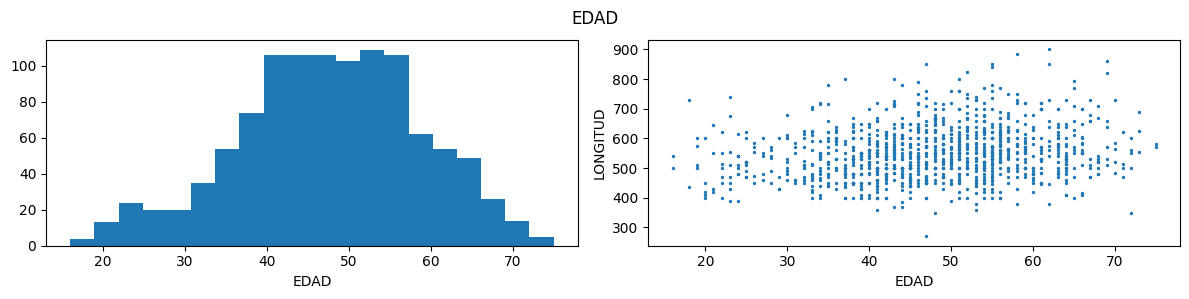

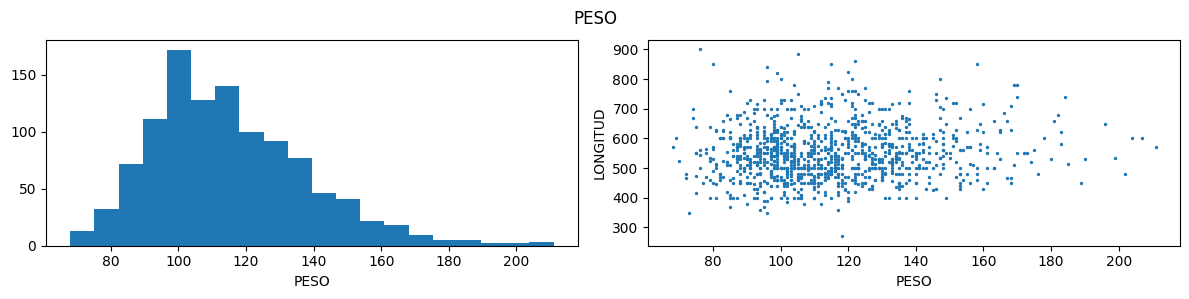

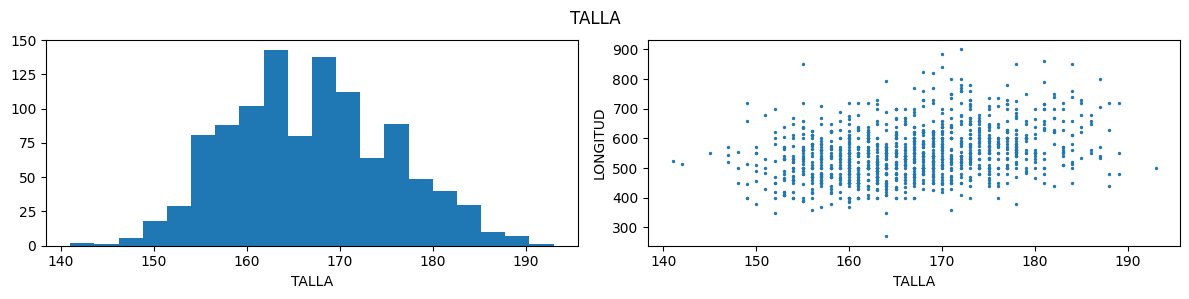

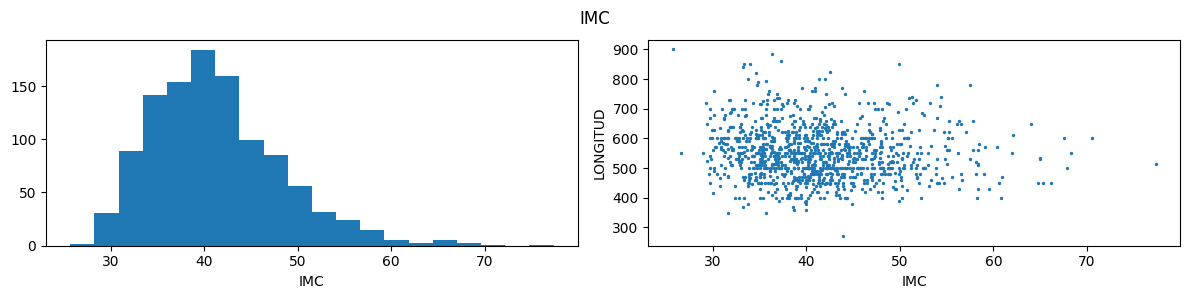

In [4]:
#data['IMClog']=np.log(data['IMC'])
num_features=['EDAD', 'PESO',	'TALLA', 'IMC']#,'IMClog']
target='LONGITUD'

# For each numeric variable...
for col in num_features:

    # Determine data to focus on
    x = data[col].copy()
    y = data[target].copy()

    # Generate interface for two graphs
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    fig.suptitle(col)

    # Draw on the left the histogram with the distribution of the variable
    axs[0].hist(x, bins=20)
    axs[0].set_xlabel(col)

    # Draw the scatterplot on the right with the interaction between the variable of interest and the response variable
    axs[1].scatter(x, y, s=2)
    axs[1].set_xlabel(col)
    axs[1].set_ylabel(target)

    # show visualization
    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.show()

<p><font color='blue'>
EDAD distribucion normal<br>
IMC distribucion asimetrica
</font><p>

### Variables categoricas

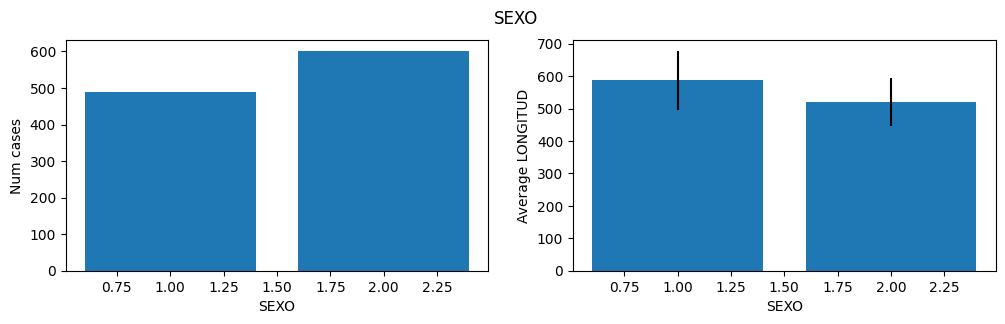

In [5]:
# Interaction variable definition
id='INICIALES'
cat_features= ['SEXO']#,'HTA', 'DM', 'DL', 'SAOS', 'BARIÁTRICA PREVIA']
target='LONGITUD'

# Iterate through each categorical variable...
for col in cat_features:

    # Determine data to focus on
    df_counts = data.groupby(col)[id].count()
    df_mean_target = data.groupby(col)[target].mean()
    df_std_target = data.groupby(col)[target].std()

    # Generate interface for two graphs
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))
    fig.suptitle(col)

    # Draw the bar chart with counts on the left
    x = df_counts.index.tolist()
    h = df_counts.values.tolist()
    axs[0].bar(x, h)
    axs[0].set_xlabel(col)
    axs[0].set_ylabel('Num cases')

    # Draw on the right the bar chart with interaction between categories and average response
    x = df_mean_target.index.tolist()
    h = df_mean_target.values.tolist()
    err = df_std_target.values.tolist()
    axs[1].bar(x, h, yerr=err)
    axs[1].set_xlabel(col)
    axs[1].set_ylabel(f"Average {target}")

<p><font color='blue'>
No hay valores nulos<br>
SEXO un poco desbalanceado 2-> 600 y 1->500
</font><p>

## Correlaciones

In [6]:
# A dictionary is created with the correlations between the independent variables and the objective variable
dict_corr = {}
for col in ['EDAD', 'PESO',	'TALLA','IMC','SEXO']:
    corr = data[col].corr(data[target])
    dict_corr[col] = corr

#sort and display dict
dict_corr = sorted(dict_corr.items(), key=lambda x: x[1], reverse=True)
dict_corr

[('TALLA', 0.3214971432433864),
 ('EDAD', 0.19432888831260794),
 ('PESO', 0.08935197397024912),
 ('IMC', -0.09323804833189256),
 ('SEXO', -0.3741018130148069)]

<ipython-input-7-06fb7681be72>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


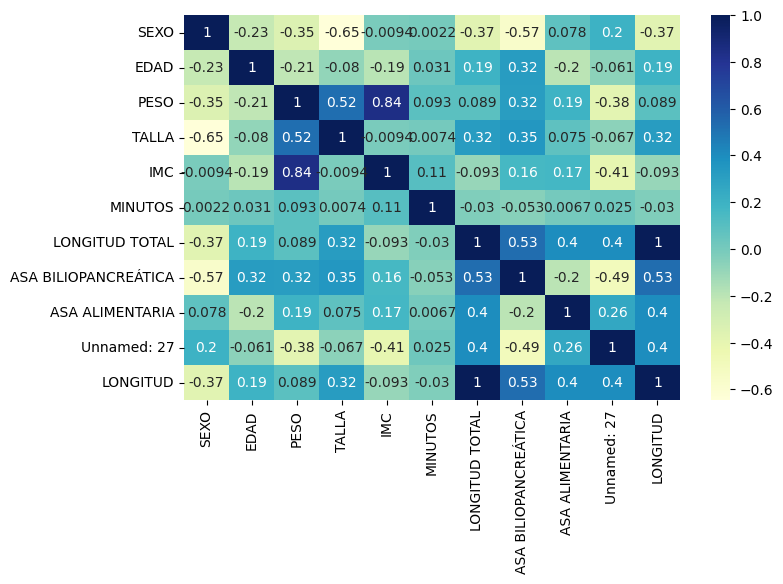

In [7]:
corr_matrix = data.corr()
#print(corr_matrix)
plt.subplots(figsize=(8,5))
sn.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

In [8]:
#https://eqibuana.medium.com/how-to-test-correlation-between-categorical-and-continuous-variables-in-data-science-95dca3704144
from scipy.stats import f_oneway

def ANOVA_Test(df, feature):
    category_groups = df.groupby(feature)[target].apply(list)
    return f_oneway(*category_groups)

p_vals = {}
for col in data[cat_features].columns:
    p_vals[col] = ANOVA_Test(data, col).statistic
#p_vals.pop(target)
sorted(p_vals.items(),key=lambda item: item[1],reverse=True)

[('SEXO', 177.04591677600072)]

<p><font color='blue'>
EDAD correlaciona un poquito<br>
IMC nada<br>
SEXO mayor correlacion, numerica<br>
</font><p>

## Transformación de los datos


### Seleccion

<p><font color='blue'>
SELECCION DE VARIABLES<br>
Las que no tienen hay valores nulos -> iniciales, municipio, tecnica -drop<br>
ciudad y fechas() fecha ingreso, fecha parte, fecha alta, hora inicio, hora final) habria que transformarlas, - ??</font><p>

In [9]:
#seleccion de variables
#iniciales, municipio, tecnica -drop
#ciudad y fechas() fecha ingreso, fecha parte, fecha alta, hora inicio, hora final) habria que transformarlas, - ??
select_features=['EDAD', 'PESO','TALLA', 'IMC','SEXO']# 'IMC', 'HTA', 'DM', 'DL', 'SAOS' , 'BARIÁTRICA PREVIA', 'MINUTOS','ESTANCIA' ]
predict_feature= ['LONGITUD']
select_data=data[select_features].copy()

#categorical data - not ordinal
#sexo, dm, hta,'DM', 'DL', 'SAOS', 'BARIÁTRICA PREVIA' - onhotencoding -> OJO IMBALANCED, OJO SI SON ORDINALES
categorical_cols = ['SEXO']#,'HTA', 'DM', 'DL', 'SAOS', 'BARIÁTRICA PREVIA']
transformed_data = pd.get_dummies(select_data, columns = categorical_cols)

#numerical data
#minutos, edad, imc - numericas
transformed_columns=list(transformed_data.columns)
transformed_data.head()

,EDAD,PESO,TALLA,IMC,SEXO_1,SEXO_2
0,37,97,172.0,32.787994,0,1
1,69,122,181.0,37.239401,1,0
2,55,96,170.0,33.217993,1,0
3,60,112,165.0,41.138659,0,1
4,53,82,154.0,34.575814,0,1


### scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler

# df0 -> DataFrames not scaled
# df1   -> DataFrame scaled but not LONGITUD  - scaler1
# df2   -> DataFrame scaled                   - scaler2

X= transformed_data.copy()
y= data[predict_feature].copy()
df0= transformed_data.copy()
df0[predict_feature]= data[predict_feature].copy()
display(df0)
display(df0.describe().transpose())


scaler1=MinMaxScaler()
X1 = scaler1.fit_transform(X)  #inverse_transform()

df1= pd.DataFrame(X1, columns=transformed_columns)
df1[predict_feature]=y
display(df1)
display(df1.describe().transpose())

scaler2=MinMaxScaler()
X2=transformed_data.copy()
X2[predict_feature]=data[predict_feature].copy()
X_ = scaler2.fit_transform(X2)  #inverse_transform()

df2= pd.DataFrame(X_, columns=transformed_columns+['LONGITUD'])
display(df2)
display(df2.describe().transpose())

,EDAD,PESO,TALLA,IMC,SEXO_1,SEXO_2,LONGITUD
0,37,97,172.0,32.787994,0,1,590
1,69,122,181.0,37.239401,1,0,860
2,55,96,170.0,33.217993,1,0,840
3,60,112,165.0,41.138659,0,1,480
4,53,82,154.0,34.575814,0,1,460
...,...,...,...,...,...,...,...
1085,39,85,155.0,35.379813,0,1,400
1086,39,148,180.0,45.679012,1,0,540
1087,54,161,157.0,65.317051,0,1,450
1088,63,145,177.0,46.282997,1,0,600


,count,mean,std,min,25%,50%,75%,max
EDAD,1090.0,47.708257,11.380764,16.000000,41.000000,48.000000,55.000000,75.000000
PESO,1090.0,115.025688,23.018723,68.000000,98.000000,112.000000,129.000000,211.000000
TALLA,1090.0,166.743119,8.734849,141.000000,160.000000,166.000000,173.000000,193.000000
IMC,1090.0,41.264023,7.035458,25.689562,36.143848,40.346505,45.129549,77.365602
SEXO_1,1090.0,0.447706,0.497486,0.000000,0.000000,0.000000,1.000000,1.000000
SEXO_2,1090.0,0.552294,0.497486,0.000000,0.000000,1.000000,1.000000,1.000000
LONGITUD,1090.0,550.582569,88.519893,270.000000,490.000000,540.000000,600.000000,900.000000


,EDAD,PESO,TALLA,IMC,SEXO_1,SEXO_2,LONGITUD
0,0.355932,0.202797,0.596154,0.137364,0.0,1.0,590
1,0.898305,0.377622,0.769231,0.223505,1.0,0.0,860
2,0.661017,0.195804,0.557692,0.145685,1.0,0.0,840
3,0.745763,0.307692,0.461538,0.298961,0.0,1.0,480
4,0.627119,0.097902,0.250000,0.171961,0.0,1.0,460
...,...,...,...,...,...,...,...
1085,0.389831,0.118881,0.269231,0.187519,0.0,1.0,400
1086,0.389831,0.559441,0.750000,0.386822,1.0,0.0,540
1087,0.644068,0.650350,0.307692,0.766845,0.0,1.0,450
1088,0.796610,0.538462,0.692308,0.398510,1.0,0.0,600


,count,mean,std,min,25%,50%,75%,max
EDAD,1090.0,0.537428,0.192894,0.0,0.423729,0.542373,0.661017,1.0
PESO,1090.0,0.328851,0.160970,0.0,0.209790,0.307692,0.426573,1.0
TALLA,1090.0,0.495060,0.167978,0.0,0.365385,0.480769,0.615385,1.0
IMC,1090.0,0.301386,0.136145,0.0,0.202304,0.283631,0.376190,1.0
SEXO_1,1090.0,0.447706,0.497486,0.0,0.000000,0.000000,1.000000,1.0
SEXO_2,1090.0,0.552294,0.497486,0.0,0.000000,1.000000,1.000000,1.0
LONGITUD,1090.0,550.582569,88.519893,270.0,490.000000,540.000000,600.000000,900.0


,EDAD,PESO,TALLA,IMC,SEXO_1,SEXO_2,LONGITUD
0,0.355932,0.202797,0.596154,0.137364,0.0,1.0,0.507937
1,0.898305,0.377622,0.769231,0.223505,1.0,0.0,0.936508
2,0.661017,0.195804,0.557692,0.145685,1.0,0.0,0.904762
3,0.745763,0.307692,0.461538,0.298961,0.0,1.0,0.333333
4,0.627119,0.097902,0.250000,0.171961,0.0,1.0,0.301587
...,...,...,...,...,...,...,...
1085,0.389831,0.118881,0.269231,0.187519,0.0,1.0,0.206349
1086,0.389831,0.559441,0.750000,0.386822,1.0,0.0,0.428571
1087,0.644068,0.650350,0.307692,0.766845,0.0,1.0,0.285714
1088,0.796610,0.538462,0.692308,0.398510,1.0,0.0,0.523810


,count,mean,std,min,25%,50%,75%,max
EDAD,1090.0,0.537428,0.192894,0.0,0.423729,0.542373,0.661017,1.0
PESO,1090.0,0.328851,0.160970,0.0,0.209790,0.307692,0.426573,1.0
TALLA,1090.0,0.495060,0.167978,0.0,0.365385,0.480769,0.615385,1.0
IMC,1090.0,0.301386,0.136145,0.0,0.202304,0.283631,0.376190,1.0
SEXO_1,1090.0,0.447706,0.497486,0.0,0.000000,0.000000,1.000000,1.0
SEXO_2,1090.0,0.552294,0.497486,0.0,0.000000,1.000000,1.000000,1.0
LONGITUD,1090.0,0.445369,0.140508,0.0,0.349206,0.428571,0.523810,1.0


## CLUSTERING

### evaluation

In [11]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
import time

def form_clusters(x,k):
    """Build clusters"""
    # k=required number of clusters
    # n_jobs = 1 # 1 no parallel implementation, -1 all cores used
    model = KMeans(init='k-means++', n_clusters=k, n_init=10, verbose=0, random_state=42)


    t0 = time.time()
    model.fit(x)
    t_model = time.time() - t0

    labels = model.labels_
    inertia = model.inertia_
    centroids = model.cluster_centers_ #np.sort(model.cluster_centers_)

    #Cacluate the silhouette	score
    sh_score = silhouette_score(x,labels)
    print('%i clusers - %f seconds - %f silouhette coef - %f cost' % ( k , t_model, sh_score, inertia))
    return sh_score, inertia, centroids

3 clusers - 0.063740 seconds - 0.546146 silouhette coef - 1615730.380023 cost
4 clusers - 0.093881 seconds - 0.535721 silouhette coef - 994634.050473 cost
5 clusers - 0.099411 seconds - 0.534792 silouhette coef - 690217.178600 cost
6 clusers - 0.102954 seconds - 0.539462 silouhette coef - 498493.763365 cost
7 clusers - 0.103674 seconds - 0.537321 silouhette coef - 383458.399380 cost
8 clusers - 0.050825 seconds - 0.552193 silouhette coef - 272694.022869 cost
9 clusers - 0.203885 seconds - 0.557012 silouhette coef - 216390.991873 cost


Text(0, 0.5, 'Silhouette Coefficient')

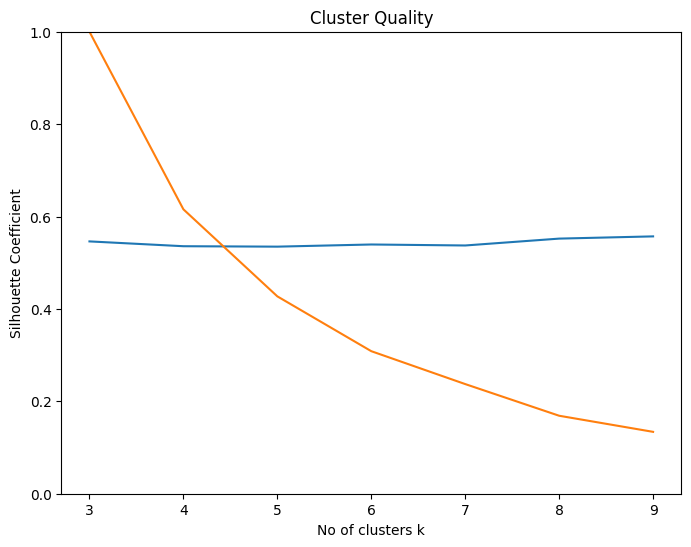

In [12]:
#EVALUATING THE ALGORITHM
#########################

#1) settings
model_used='k_means'
#model_used='mbk_means'
sh_scores = []
cost_scores = []
dict_centroids = {}
min_clusters=3
max_clusters=10
batch_size = 1000 #size of sample points to compute minibatch

#2) loop for different number of clustters k
for k in range(min_clusters,max_clusters):
    sh_score, cost, centers = form_clusters(df1[transformed_columns+['LONGITUD']],k) #'PESO','TALLA','IMC',[['EDAD','TALLA','SEXO_1','SEXO_2']]
    sh_scores.append(sh_score)
    cost_scores.append(cost)

#PLOT ELBOW AND SILOUHETTE
no_clusters = [i for i in range(min_clusters,max_clusters)]
cost_minmax = [e/max(cost_scores) for e in cost_scores] #scale cost values to max one -> % cost

plt.figure(figsize=(8,6))
plt.plot(no_clusters,sh_scores)
plt.plot(no_clusters,cost_minmax)
plt.ylim([0.0,1.0])
plt.title("Cluster Quality")
plt.xlabel("No of clusters k")
plt.ylabel("Silhouette Coefficient")

### Clustering

In [13]:
df=df1.copy()
n=0

def centroids2excel(k,centers, filename):
    dict_cent={}
    n_centroid = 0
    for c in centers:
        label_center = 'k'+str(k)+'_c'+str(n_centroid)
        array_center = [e for e in c]
        dict_cent[label_center] = array_center
        n_centroid +=1

    #STORE CENTROIDS IN excel FILE
    #print('dict_centroids->',dict_cent)
    df_cent=pd.DataFrame.from_dict(dict_cent,orient='index', columns=df.columns)
    display(df_cent)
    #print('df.columns',df.columns)
    df_cent.to_excel(filename)

for k in range(3,4):
  model = KMeans(init='k-means++', n_clusters=k, n_init=10, verbose=0, random_state=14)
  model.fit(df)

  # Centroids to excel
  centroids = model.cluster_centers_
  centroids2excel(k, centroids,'centroids_result_'+str(n)+'_'+str(k)+'.xlsx')

  # Data and centroid to excel
  labels = model.labels_
  df_result = df.copy()
  df_result['labels'] = labels

  df_result.to_excel('patients_result_'+str(n)+'_'+str(k)+'.xlsx')
  print(str(k)+'----------------------------------------------')
  display(df_result.groupby(['labels'])['labels'].count())

,EDAD,PESO,TALLA,IMC,SEXO_1,SEXO_2,LONGITUD
k3_c0,0.494308,0.314946,0.442451,0.314398,0.251244,0.748756,465.223881
k3_c1,0.548125,0.331002,0.502486,0.299122,0.486869,0.513131,564.585859
k3_c2,0.599807,0.352295,0.585592,0.280093,0.756477,0.243523,692.461140


3----------------------------------------------


labels
0    402
1    495
2    193
Name: labels, dtype: int64

### transforming

In [14]:
#OPTION TRANSFORM
##################################

#display(centroids)
centroids_transformed_ = scaler1.inverse_transform(centroids[:,:-1])
centroids_allfeatures=np.hstack((centroids_transformed_,centroids[:,-1:]))
centroids2excel(2, centroids_allfeatures,'centroids_escalados_result'+str(n)+'_'+str(k)+'.xlsx')


#centroids_transformed_ = scaler2.inverse_transform(centroids)
#centroids_allfeatures=centroids_transformed_
#centroids2excel(2, centroids_allfeatures,'centroids_escalados_result'+str(n)+'_'+str(k)+'.xlsx')

## copiar datos originales sin escalar y pegar etiquetas -> patients_escalados_result.xlsx

,EDAD,PESO,TALLA,IMC,SEXO_1,SEXO_2,LONGITUD
k2_c0,45.164179,113.037313,164.007463,41.936419,0.251244,0.748756,465.223881
k2_c1,48.339394,115.333333,167.129293,41.146977,0.486869,0.513131,564.585859
k2_c2,51.388601,118.378238,171.450777,40.163683,0.756477,0.243523,692.461140


### explore results

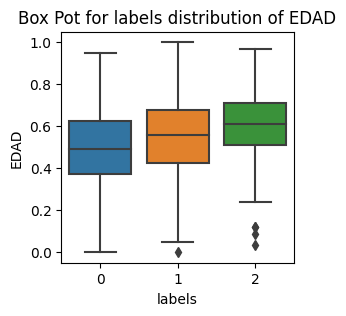

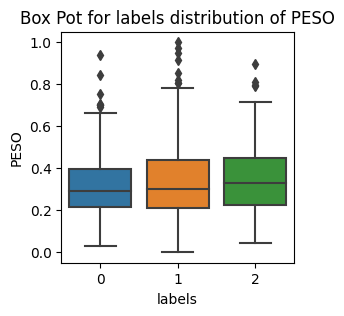

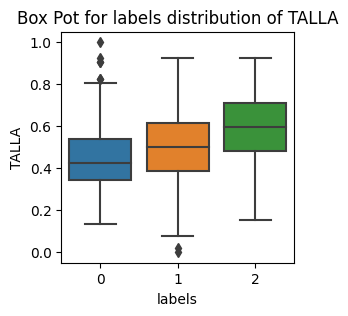

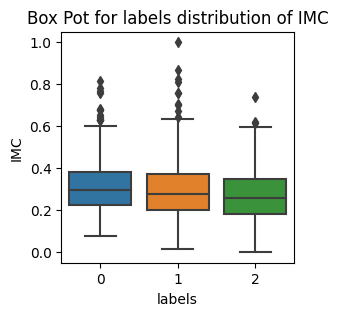

In [15]:
#data['IMClog']=np.log(data['IMC'])
num_features=select_features[:-1] #sin 'SEXO', ni 'SEXO_1', ni	'SEXO_2',
target='LONGITUD'

# For each numeric variable...
for col in num_features:
  fig,ax = plt.subplots(figsize=(3,3))
  sn.boxplot(df_result[['labels',col]],x="labels",y=col,ax=ax)
  ax.set(title="Box Pot for labels distribution of "+col)

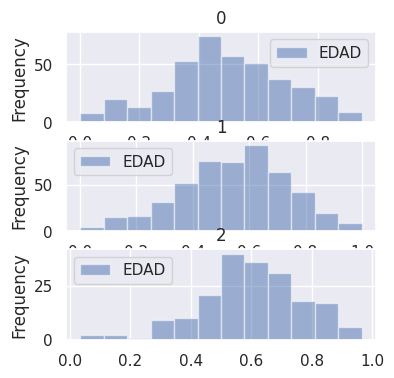

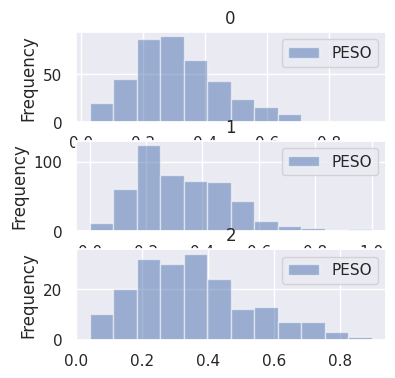

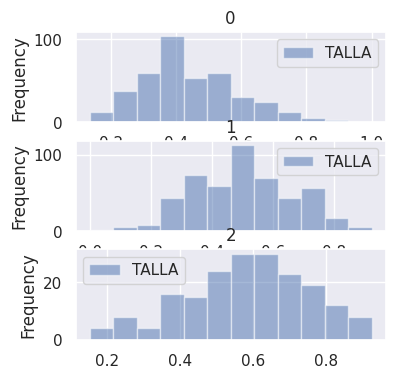

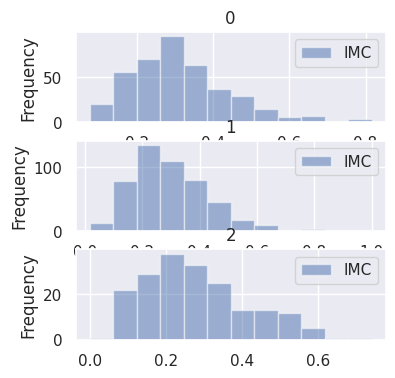

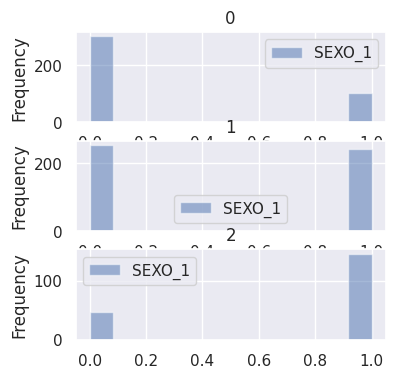

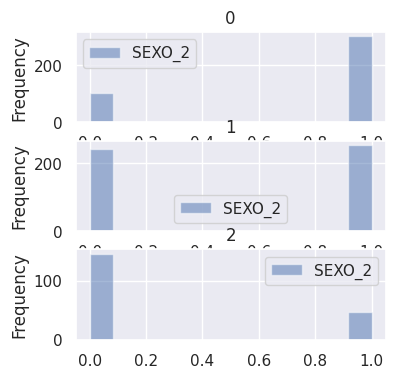

In [ ]:
for col in num_features+['SEXO_1', 'SEXO_2']:
  df_result[[col,'labels']].plot.hist(bins=12, alpha=0.5, by='labels',legend=True, figsize=(4,4))

### Data Interpolation



In [16]:
#instalacion de las librerías
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [17]:
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SMOTENC

sm = SMOTE(random_state=42)#creamos el estimador con random_state=42
#sm = BorderlineSMOTE(random_state=42)
#sm = SMOTENC(categorical_features=[0, 1],random_state=42)


#Fitting and sampling can also be done in one step with .fit_sample
#data_resampled, targets_resampled = <estimator>.fit_sample(data, targets)
X_res, Y_res = sm.fit_resample(df_result[transformed_columns].copy(), df_result['labels'].copy())

In [20]:
df_enriched=X_res.copy()
df_enriched['labels']=Y_res.copy()
display(df_enriched.groupby(['labels'])['labels'].count())

labels
0    495
1    495
2    495
Name: labels, dtype: int64

## Modeling

23--------------------------
              precision    recall  f1-score   support

           0       0.62      0.74      0.67        46
           1       0.63      0.50      0.56        48
           2       0.86      0.87      0.86        55

    accuracy                           0.71       149
   macro avg       0.70      0.70      0.70       149
weighted avg       0.71      0.71      0.71       149



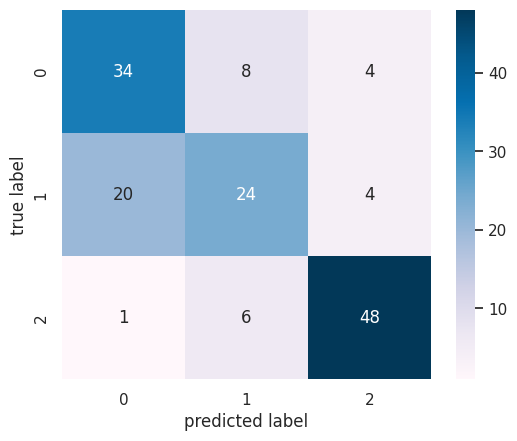

In [42]:
#X= df_result[['EDAD', 'IMC', 'SEXO_1', 'SEXO_2']].copy()
#y= df_result['labels'].copy()

X= df_enriched[transformed_columns].copy()
y= df_enriched['labels'].copy()

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=23) # 80% training and 20% test

X_eval= X_test.copy()
y_eval= y_test.copy()
#y_pred= GradientBoostingClassifier(n_estimators=100, learning_rate = 0.01, max_features=5, max_depth = 10, random_state = 26).fit(X_train,y_train).predict(X_eval)
#nestimators50-max_depth20-lr0.05mf1-66.0
#y_pred= GradientBoostingClassifier(n_estimators=50, learning_rate = 0.05, max_features=1, max_depth = 20, random_state = 26).fit(X_train,y_train).predict(X_eval)

#nestimators150-max_depth8-lr0.5mf3-67.0
y_pred= GradientBoostingClassifier(n_estimators=150, learning_rate = 0.5, max_features=3, max_depth = 8, random_state = 26).fit(X_train,y_train).predict(X_eval)

#confussion matrix metrics
print(str(23)+'--------------------------')
print(metrics.classification_report(y_eval,y_pred))
#confusion matrix plot
sn.set()
mat = confusion_matrix(y_eval, y_pred)
sn.heatmap(mat, square=True, annot=True, fmt='d', cbar=True, cmap='PuBu')
plt.xlabel('predicted label')
plt.ylabel('true label');

### Model tunning

mejores:

nestimators50-max_depth20-lr0.05mf1-66.0

nestimators150-max_depth8-lr0.5mf3-67.0


In [40]:
#n_estimators=100, learning_rate = 0.01, max_features=5, max_depth = 10
#n_estimator 25 max_depth 3 learning_rate 0.001 max_features 5 scores.mean 0.5696969696969696
n_estimators = [25,50,100,125,150,175,200]
max_depths = [2,3,5,7,8,9,10,15,20,25]
learning_rates = [0.001,0.01,0.05,0.1,0.2,0.5]
max_features=[1,3,5,10,15,20]
maxmean = 0
X_eval= X_test.copy()
y_eval= y_test.copy()

for n_estimator in n_estimators:
  for max_depth in max_depths:
    for lr in learning_rates:
      for mf in max_features:
        y_pred= GradientBoostingClassifier(n_estimators=n_estimator, learning_rate = lr, max_features=mf, max_depth = max_depth, random_state = 26).fit(X_train,y_train).predict(X_eval)

        #confussion matrix metrics
        m=metrics.classification_report(y_eval,y_pred)

        if maxmean<100*float(m.split('\n')[2].split('      ')[4]):
          maxmean=100*float(m.split('\n')[2].split('      ')[4])
          print('nestimators'+str(n_estimator)+'-max_depth'+str(max_depth)+'-lr'+str(lr)+'mf'+str(mf)+'-'+str(maxmean)+'--------------------------')
          print(m)


nestimators25-max_depth2-lr0.001mf1-57.99999999999999--------------------------
              precision    recall  f1-score   support

           0       0.46      0.78      0.58        46
           1       0.30      0.42      0.35        48
           2       1.00      0.05      0.10        55

    accuracy                           0.40       149
   macro avg       0.58      0.42      0.34       149
weighted avg       0.61      0.40      0.33       149

nestimators25-max_depth2-lr0.001mf3-60.0--------------------------
              precision    recall  f1-score   support

           0       0.49      0.76      0.60        46
           1       0.40      0.42      0.41        48
           2       0.71      0.36      0.48        55

    accuracy                           0.50       149
   macro avg       0.54      0.51      0.50       149
weighted avg       0.54      0.50      0.49       149

nestimators25-max_depth7-lr0.001mf10-61.0--------------------------
              precision

### pyCaret

In [ ]:
#after installing packages restart the environment
!pip install pycaret

In [ ]:
#https://pycaret.gitbook.io/docs/
from pycaret.classification import *

data_in=df_enriched[['EDAD', 'IMC', 'SEXO_1', 'SEXO_2', 'labels']].copy()

s=setup(data_in,target='labels', session_id=123) #, remove_outliers = True , feature_selection = True

,Description,Value
0,Session id,123
1,Target,labels
2,Target type,Multiclass
3,Original data shape,"(1497, 5)"
4,Transformed data shape,"(1497, 5)"
5,Transformed train set shape,"(1047, 5)"
6,Transformed test set shape,"(450, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [ ]:
#find best model
best = compare_models()
print(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.5473,0.7069,0.5473,0.5375,0.5366,0.3210,0.3248,0.4720
lr,Logistic Regression,0.5367,0.7117,0.5367,0.5069,0.4905,0.3051,0.3235,1.2570
lda,Linear Discriminant Analysis,0.5358,0.7120,0.5358,0.5028,0.4883,0.3037,0.3223,0.0290
nb,Naive Bayes,0.5330,0.6736,0.5330,0.5095,0.4540,0.2994,0.3335,0.0270
ada,Ada Boost Classifier,0.5330,0.6994,0.5330,0.5198,0.5164,0.2996,0.3055,0.2010
ridge,Ridge Classifier,0.5310,0.0000,0.5310,0.5041,0.4526,0.2965,0.3297,0.0260
et,Extra Trees Classifier,0.5282,0.7189,0.5282,0.5254,0.5249,0.2923,0.2935,0.2180
lightgbm,Light Gradient Boosting Machine,0.5224,0.7027,0.5224,0.5220,0.5192,0.2838,0.2856,0.9590
rf,Random Forest Classifier,0.5214,0.7208,0.5214,0.5183,0.5176,0.2821,0.2835,0.2650
xgboost,Extreme Gradient Boosting,0.5177,0.6975,0.5177,0.5171,0.5145,0.2765,0.2781,0.1410


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='log_loss', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=1,
                           min_samples_split=2, min_weight_fraction_leaf=0.0,
                           n_estimators=100, n_iter_no_change=None,
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
